# Forecasting - BTC

1) Imports

In [1]:
import warnings
import requests
import json
import pandas as pd
from datetime import datetime, date
warnings.filterwarnings("ignore")
from ts_utils import *

2) Coleta de dados

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
hj = date.today()
futuro_day = date.fromordinal(hj.toordinal()+30) # hoje + 30 dias
print("Data Limite Previsão",futuro_day)

Num GPUs Available:  0
Data Limite Previsão 2021-06-28


In [3]:


# Pegando dados da Api
dtf = get_data('btc', sample_data=False)
# Convertendo timestamp para data
DS = []
for result in dtf['time']:
    DS.append(datetime.fromtimestamp(result))
dtf = pd.DataFrame([DS, dtf['close']]).T
dtf.head()


Buscando  todas  observações da moeda BTC
Dataset foi carregado! Formatando Dataset ...


,0,1
0,2010-07-16 21:00:00,0.04951
1,2010-07-17 21:00:00,0.08584
2,2010-07-18 21:00:00,0.0808
3,2010-07-19 21:00:00,0.07474
4,2010-07-20 21:00:00,0.07921


In [4]:
dtf.columns = ['date', 'close']
ts = dtf.groupby("date")["close"].sum().rename("sales")
ts.tail()

date
2021-05-24 21:00:00    38387.36
2021-05-25 21:00:00    39295.08
2021-05-26 21:00:00    38538.84
2021-05-27 21:00:00    35680.92
2021-05-28 21:00:00    36382.16
Name: sales, dtype: float64

3) Analise de séries temporais

Numero de observações:  3970
Valor maximo: $ 63558.48
Valor minimo: $ 0.04951


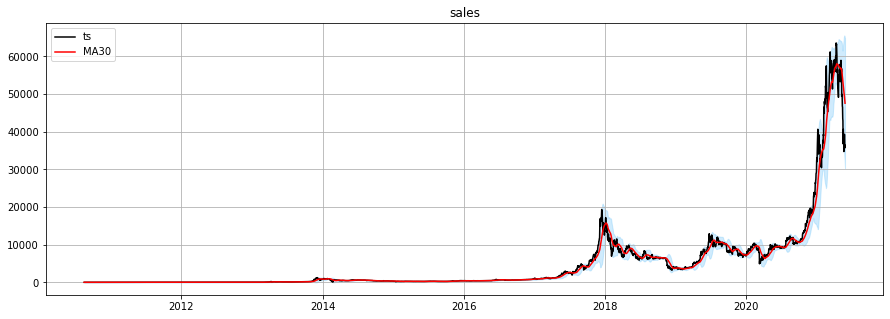

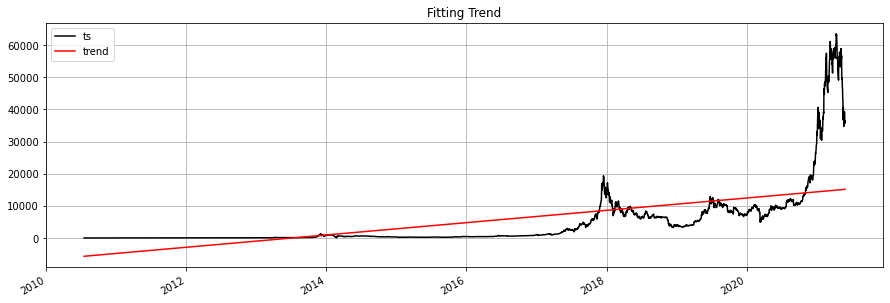

In [5]:
print("Numero de observações: ",len(ts))
print("Valor maximo: $",max(ts))
print("Valor minimo: $",min(ts))
w = 30
plot_ts(ts, plot_ma=True, plot_intervals=True, window=w, figsize=(15,5))
trend, line = fit_trend(ts, degree=1, plot=True, figsize=(15,5))

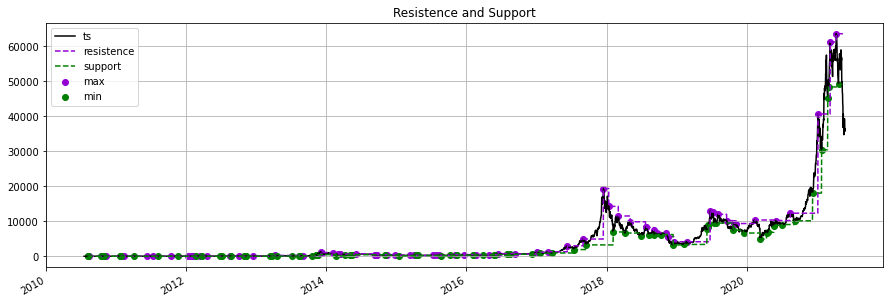

In [6]:
# Analise de maximos e minimos
res_sup = resistence_support(ts, window=30, trend=False, plot=True, figsize=(15,5))

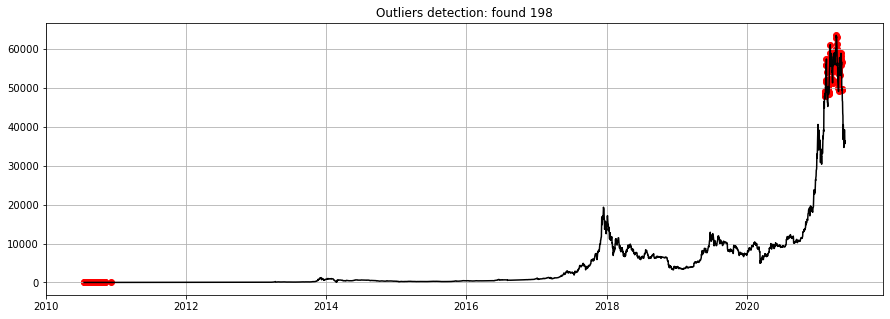

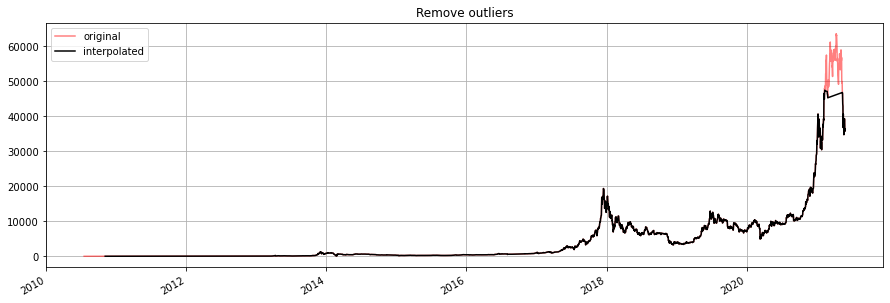

In [7]:
#Removendo outliers
dtf_outliers = find_outliers(ts, perc=0.05, figsize=(15,5))
ts_clean = remove_outliers(ts, outliers_idx=dtf_outliers[dtf_outliers["outlier"]==1].index, figsize=(15,5))

4) Processamento

--- splitting at index:  3930 | 2021-04-19 21:00:00 | test size: 0.01  ---


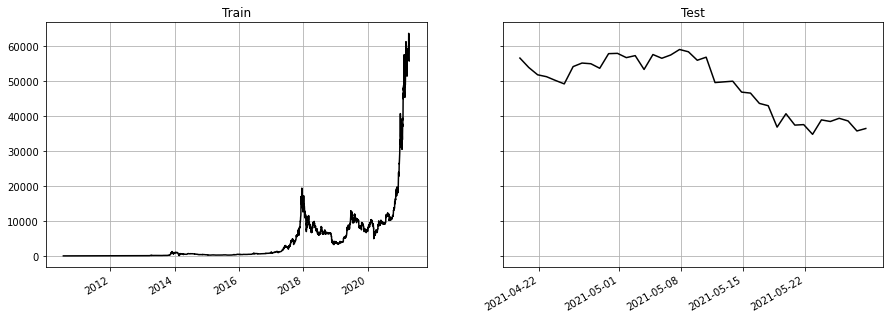

train: 3930 obs  |  test: 40 obs


In [8]:
ts_train, ts_test = split_train_test(ts, exog=None, test=0.01, plot=True, figsize=(15,5))
print("train:", len(ts_train), "obs  |  test:", len(ts_test), "obs")

5) Arima

C:\Users\Tulio Caproni\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Tulio Caproni\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Tulio Caproni\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Tulio Caproni\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Tulio Caproni\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWa

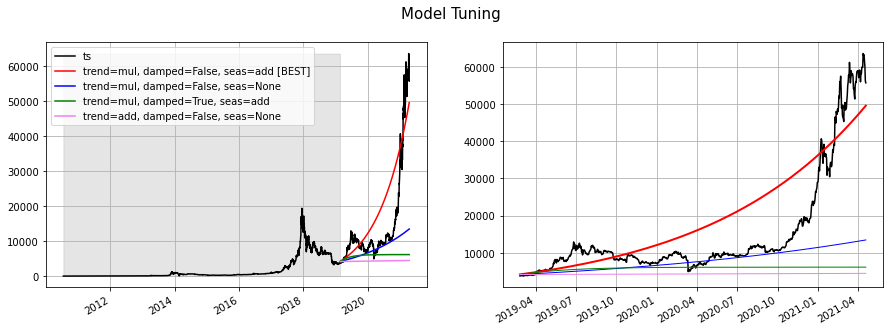

,combo,score,model
0,"trend=mul, damped=False, seas=add",6990.177772,<statsmodels.tsa.holtwinters.results.HoltWinte...
1,"trend=mul, damped=False, seas=None",7207.859555,<statsmodels.tsa.holtwinters.results.HoltWinte...
2,"trend=mul, damped=True, seas=add",9162.618419,<statsmodels.tsa.holtwinters.results.HoltWinte...
3,"trend=add, damped=False, seas=None",10684.296879,<statsmodels.tsa.holtwinters.results.HoltWinte...
4,"trend=add, damped=False, seas=add",10695.428535,<statsmodels.tsa.holtwinters.results.HoltWinte...


In [9]:
# Tuning
s=7
res = tune_expsmooth_model(ts_train, s=s, val_size=0.2, scoring=metrics.mean_absolute_error, top=4, figsize=(15,5))
res.head()

C:\Users\Tulio Caproni\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Tulio Caproni\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
--- generating index date --> start: 2021-05-29 21:00:00 | end: 2021-06-27 21:00:00 | len: 30 ---
--- computing confidence interval ---


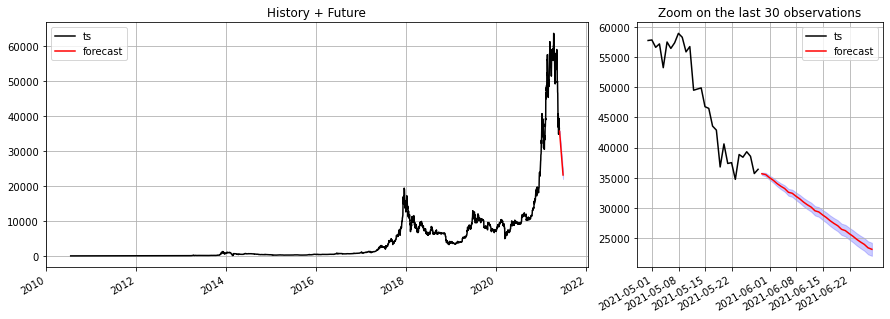

In [10]:
# Forecast unknown
model = smt.ExponentialSmoothing(ts, trend="additive", damped=False, 
                                 seasonal="multiplicative", seasonal_periods=s).fit(0.64)

future = forecast_autoregressive(ts, model, end=futuro_day, conf=0.30, zoom=30, figsize=(15,5))

C:\Users\Tulio Caproni\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Tulio Caproni\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Tulio Caproni\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Tulio Caproni\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Tulio Caproni\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.

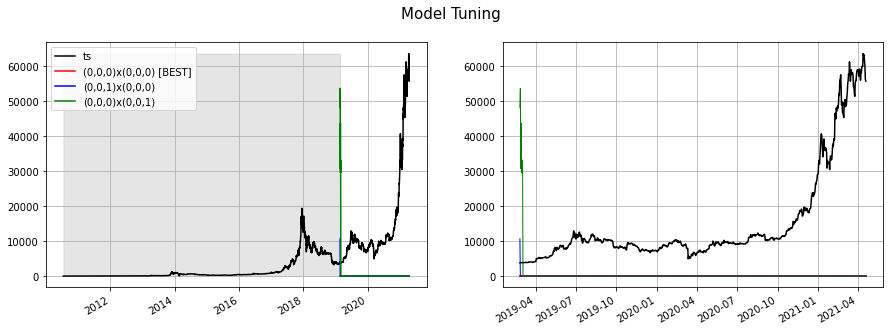

,combo,score,model
0,"(0,0,0)x(0,0,0)",14966.919796,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,"(0,0,1)x(0,0,0)",14970.834228,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,"(0,0,0)x(0,0,1)",15244.153866,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,"(0,0,1)x(0,0,1)",15254.384556,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,"(1,0,0)x(0,0,0)",38709.392520,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [11]:
# *pode demorar
res = tune_arima_model(ts_train, s=s, val_size=0.2, max_order=(1,1,1), seasonal_order=(1,0,1),
                        scoring=metrics.mean_absolute_error, top=3, figsize=(15,5))
res.head()

In [12]:
# *pode demorar
find_best_sarimax(ts_train, seasonal=True, stationary=False, s=s, exog=None,
                  max_p=10, max_d=3, max_q=10, 
                  max_P=1, max_D=1, max_Q=1)

C:\Users\Tulio Caproni\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\Tulio Caproni\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\Tulio Caproni\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\Tulio Caproni\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\Tulio Caproni\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\Tulio Caproni\Anacond

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 3930
Model:             SARIMAX(2, 2, 1)x(1, 0, 1, 7)   Log Likelihood              -29140.963
Date:                           Sat, 29 May 2021   AIC                          58295.926
Time:                                   00:45:38   BIC                          58339.857
Sample:                                        0   HQIC                         58311.513
                                          - 3930                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0209      0.040      0.523      0.601      -0.057       0.099
ar.L1         -0.0217      0.005     -4.820      0.000      -0.031      -0.013
ar.L2          0.0233      0.004      5.260      0.000       0.015       0.032
ma.L1         -0.9861      0.001   -880.764      0.000      -0.988      -0.984
ar.S.L7        0.6000      0.016     37.815      0.000       0.569       0.631
ma.S.L7       -0.7351      0.014    -52.817      0.000      -0.762      -0.708
sigma2      1.625e+05    677.245    239.981      0.000    1.61e+05    1.64e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            701071.46
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):             937.81   Skew:                             0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        68.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Trend parameters: d=1
Seasonal parameters: Seasonality every 7 observations
Exog parameters: Not given
C:\Users\Tulio Caproni\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Tulio Caproni\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


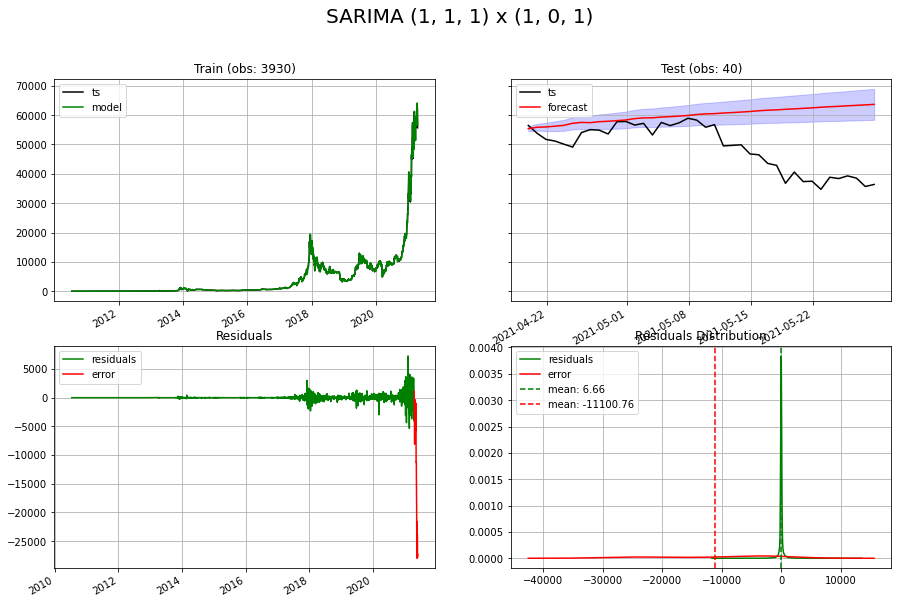

Training --> Residuals mean: 7.0  | std: 403.0
Test --> Error mean: -11101.0  | std: 9976.0  | mae: 11156.0  | mape: 27.0 %  | mse: 220267354.0  | rmse: 14841.0


In [13]:
# Traino/Test
dtf, model = fit_sarimax(ts_train, ts_test, order=(1,1,1), seasonal_order=(1,0,1), s=s, conf=0.95, figsize=(15,10))

C:\Users\Tulio Caproni\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Tulio Caproni\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
--- generating index date --> start: 2021-05-29 21:00:00 | end: 2021-06-27 21:00:00 | len: 30 ---


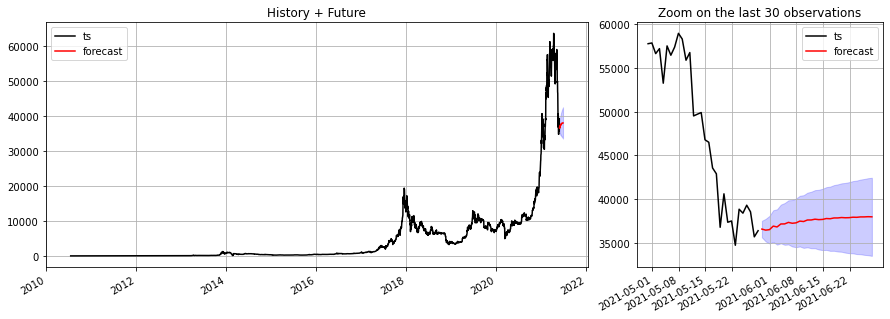

In [14]:
# previsão
model = smt.SARIMAX(ts, order=(1,1,1), seasonal_order=(1,0,1,s), exog=None).fit()

future = forecast_autoregressive(ts, model, end=futuro_day, conf=0.95, zoom=30, figsize=(15,5))

6) LSTM

In [15]:
s = 30
n_features = 1

In [16]:
model = models.Sequential()
model.add( layers.LSTM(input_shape=(s,n_features), units=50, activation='relu', return_sequences=True) )
model.add( layers.Dropout(0.2) )
model.add( layers.LSTM(units=50, activation='relu', return_sequences=False) )
model.add( layers.Dense(1) )
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 30, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


Seasonality: using the last 30 observations to predict the next 1
--- X: (3900, 30, 1) | y: (3900,) ---
--- computing confidence interval ---


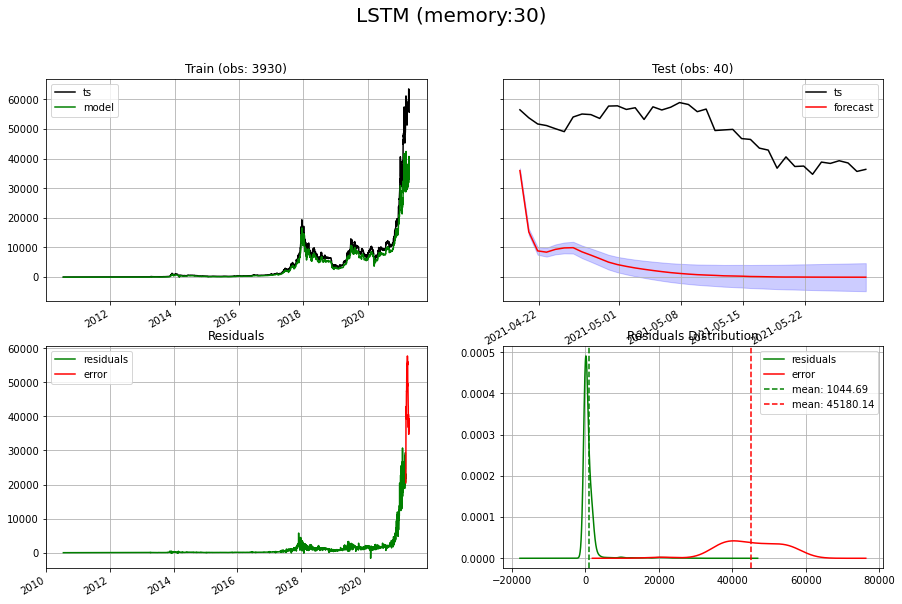

Training --> Residuals mean: 1045.0  | std: 2997.0
Test --> Error mean: 45180.0  | std: 8114.0  | mae: 45180.0  | mape: 93.0 %  | mse: 2105442639.0  | rmse: 45885.0


In [17]:
dtf, model = fit_lstm(ts_train, ts_test, model, exog=None, s=s, epochs=100, conf=0.20, figsize=(15,10))

--- generating index date --> start: 2021-05-29 21:00:00 | end: 2021-06-27 21:00:00 | len: 30 ---
--- computing confidence interval ---


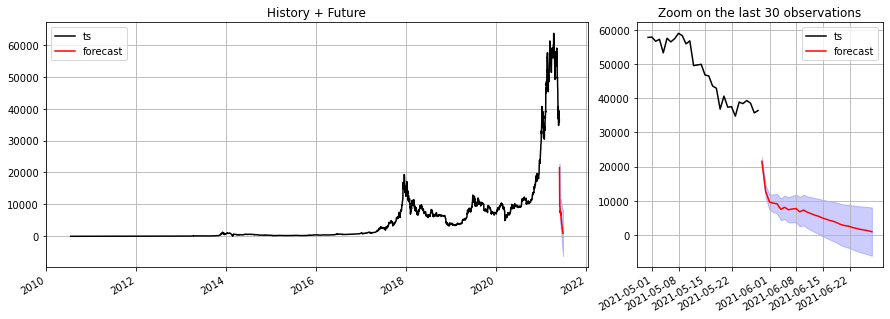

In [18]:
future = forecast_lstm(ts, model, conf=0.20, end=futuro_day, freq="D", zoom=30, figsize=(15,5))

7) Prophet

In [19]:
# Crie dataframe com colunas 'ds' (datas), 'y' (valores), 'cap' (capacidade de crescimento = "logística")
dtf_train = ts_train.reset_index().rename(columns={"date":"ds", "sales":"y"})
dtf_test = ts_test.reset_index().rename(columns={"date":"ds", "sales":"y"})

dtf_train.tail()

,ds,y
3925,2021-04-14 21:00:00,63233.03
3926,2021-04-15 21:00:00,61416.41
3927,2021-04-16 21:00:00,60056.07
3928,2021-04-17 21:00:00,56246.82
3929,2021-04-18 21:00:00,55680.11


In [20]:
# Crie feriados dataFrame com as colunas 'ds' (datas) e 'feriado' (string ex 'xmas')
dtf_holidays = None

In [21]:
model = Prophet(growth="linear", changepoints=None, n_changepoints=25, seasonality_mode="multiplicative",
                yearly_seasonality="auto", weekly_seasonality="auto", daily_seasonality=False,
                holidays=dtf_holidays, interval_width=0.80)

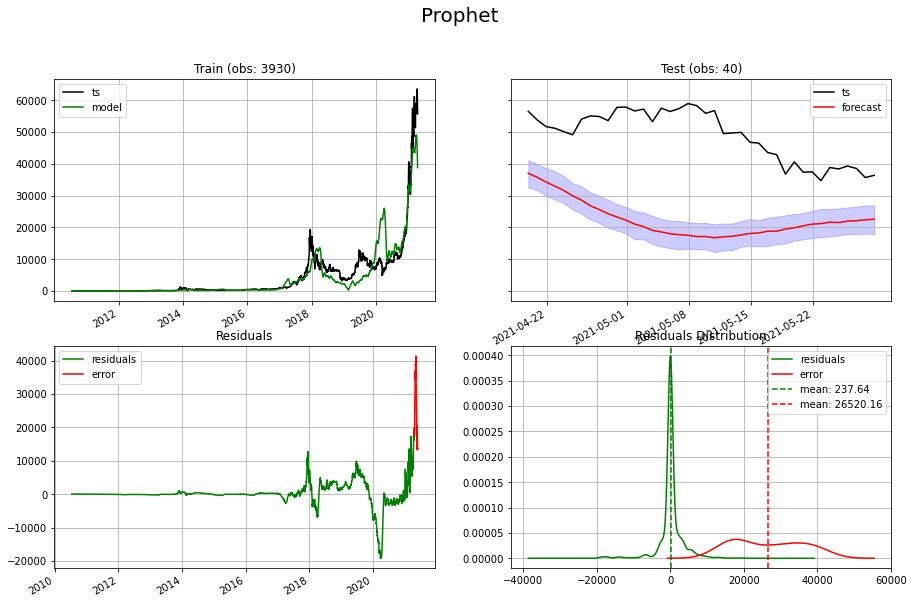

Training --> Residuals mean: 238.0  | std: 3331.0
Test --> Error mean: 26520.0  | std: 9264.0  | mae: 26520.0  | mape: 53.0 %  | mse: 786993139.0  | rmse: 28053.0


In [22]:
dtf, model = fit_prophet(dtf_train, dtf_test, model=model, freq="D", figsize=(15,10))

In [23]:
dtf = ts.reset_index().rename(columns={"date":"ds", "sales":"y"})
dtf.tail()

,ds,y
3965,2021-05-24 21:00:00,38387.36
3966,2021-05-25 21:00:00,39295.08
3967,2021-05-26 21:00:00,38538.84
3968,2021-05-27 21:00:00,35680.92
3969,2021-05-28 21:00:00,36382.16


In [24]:
model = Prophet(growth="linear", changepoints=None, n_changepoints=25, seasonality_mode="multiplicative",
                yearly_seasonality="auto", weekly_seasonality="auto", daily_seasonality=False,
                holidays=dtf_holidays, interval_width=0.80)

--- generating index date --> start: 2021-05-29 21:00:00 | end: 2021-06-27 21:00:00 | len: 30 ---


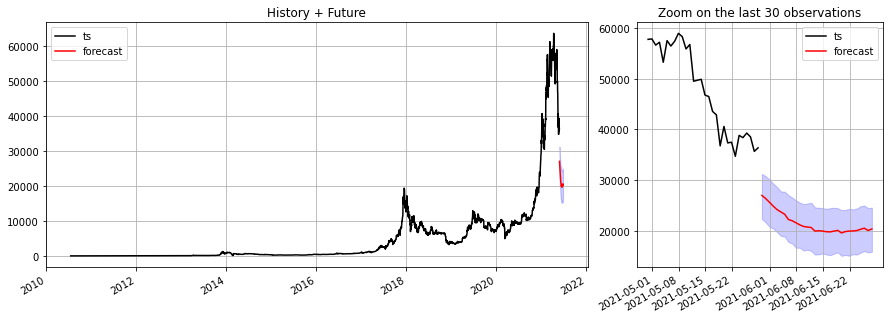

In [25]:
future = forecast_prophet(dtf, model, end=futuro_day, freq="D", zoom=30, figsize=(15,5))